So far you have seen different model evaluation metrics like accuracy, precision, recall and f1-score. After you are satisfied with the model performance, you can take the signals generated by them to trade and analyse the returns. Not only returns, but you should also analyse the risk associated with generating the returns.

This process is called backtesting.

#### Why are we backtesting the model?

Think about it, before you buy anything, be it a mobile phone or a car, you would want to check the history of the brand, its features, etc. You check if it is worth your money. The same principle applies to trading, and backtesting helps you with it. 

<b> Do you know the majority of the traders in the market lose money?</b>

They lose money not because they lack an understanding of the market. But simply because their trading decisions are not based on sound research and tested trading methods.

They make decisions based on emotions, suggestions from friends, and take excessive risks in the hope to get rich quickly. If they remove emotions and instincts from the trading and backtest the ideas before trading, then the chance to trade profitability in the market is increased.

In backtesting, you are testing a trading hypothesis/strategy on the historical data.

In the previous chapters, you took the 15-minute, 30-minute, and 75-minute prior percentage change as your features and expected that these features will help you predict the future returns. This is your hypothesis.

#### How would you test this hypothesis?

**How would you know whether the strategy will work in the market or not?<br>**

By using historical data, you can backtest and see whether your hypothesis is true or not. It helps assess the feasibility of a trading strategy by discovering how it performs on the historical data.

If you backtest your strategy on the historical data and it gives good returns, you will be confident to trade using it. If the strategy is performing poorly on the historical data, you will discard or re-evaluate the hypothesis.

We will go through a few terms and concepts which will help us analyse our strategy. But we will do this simultaneously to see how our strategy performs.

First, let us read the data files.

In the previous chapters, you have used a random forest classifier to generate the signal whether to buy J.P. Morgan's stock or not. 

The signals are stored in a CSV `JPM_predicted_2019.csv`. We will use the `read_csv` method of `pandas` to read this CSV and store it in a dataframe `strategy_data`. 

Also, we will read the close price of J.P. Morgan stored in a column `close` in the CSV file `JPM_2017_2019.csv`. 

Further, we will store it in `close` column in `strategy_data`. While reading the close price data, we will slice the period to match the signal data.

In [1]:
# For the data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# The data is stored in the directory 'data_modules'
path = '../data_modules/'

# Read the close price
strategy_data = pd.DataFrame()
strategy_data['close'] = pd.read_csv(path + "JPM_2017_2019.csv", 
                                     index_col=0)['close']

# Read the predicted signals
strategy_data['predicted_signal'] = pd.read_csv(path + \
                                  "JPM_predicted_2017_2019.csv", \
                                  index_col=0)
strategy_data.index = pd.to_datetime(strategy_data.index)
strategy_data = strategy_data.dropna()

# Preview the strategy data
strategy_data.head()

,close,predicted_signal
2019-05-28 12:00:00+00:00,109.29,0.0
2019-05-28 12:15:00+00:00,109.37,0.0
2019-05-28 12:30:00+00:00,109.33,1.0
2019-05-28 12:45:00+00:00,109.37,0.0
2019-05-28 13:00:00+00:00,109.38,0.0


The first thing you want to know from your strategy is what the returns are. Only then will you think if the trade made sense. So you will first calculate the strategy returns, as shown below.

#### Calculate Strategy Returns

In [2]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['close'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['predicted_signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,close,predicted_signal,pct_change,strategy_returns
2019-05-28 12:15:00+00:00,109.37,0.0,0.000732,0.000000
2019-05-28 12:30:00+00:00,109.33,1.0,-0.000366,-0.000000
2019-05-28 12:45:00+00:00,109.37,0.0,0.000366,0.000366
2019-05-28 13:00:00+00:00,109.38,0.0,0.000091,0.000000
2019-05-28 13:15:00+00:00,109.37,0.0,-0.000091,-0.000000


#### Trade Logs

We will create a function `get_trades`. The function will take the dataframe with the signals and close price as input along with the column names for signals and close price.

It will return a dataframe containing the details of each trade that was taken during the backtest. The following details are included for each trade:

* Trade direction (`Position`)
* Entry time
* Entry price
* Exit time
* Exit price
* Profit or Loss<br>

In [3]:
def get_trades(data, close_column, signal_column):
    # Create a dataframe to store value of each trade
    trades = pd.DataFrame()

    # Set current position as 0, 
    # and entry time aas empty
    current_position = 0
    entry_time = ''

    # Loop through each trade in dataframe
    for i in data.index:
        # Each row in the dataframe will be 
        # treated as a new position
        new_position = data.loc[i, signal_column]

        # If the position changes 
        # record the entry and exit
        if new_position != current_position:
            if entry_time != '':
                entry_price = data.loc[entry_time, 
                                       close_column]
                exit_time = i
                exit_price = data.loc[exit_time, 
                                      close_column]
                trade_details = pd.DataFrame(
                    [(current_position, entry_time, 
                      entry_price, exit_time, 
                      exit_price)])
                trades = trades.append(trade_details, 
                                       ignore_index=True)
                entry_time = ''

            if new_position != 0:
                entry_time = i
            current_position = new_position

    # Add the trade details to the `trades` dataframe
    trades.columns = ['Position', 'Entry Time',
                      'Entry Price', 'Exit Time', 
                      'Exit Price']
    trades['PnL'] = (trades['Exit Price'] -
                     trades['Entry Price']) * trades['Position']
    return trades


# Get trade details for hit ratio strategy
trade_log = get_trades(strategy_data, 'close', 
                       'predicted_signal')

trade_log.head()

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,1.0,2019-05-28 12:30:00+00:00,109.33,2019-05-28 12:45:00+00:00,109.37,0.04
1,1.0,2019-05-29 10:15:00+00:00,108.13,2019-05-29 13:00:00+00:00,107.63,-0.50
2,1.0,2019-05-31 09:45:00+00:00,105.59,2019-05-31 10:00:00+00:00,105.97,0.38
3,1.0,2019-06-04 10:30:00+00:00,108.44,2019-06-04 13:15:00+00:00,109.21,0.77
4,1.0,2019-06-04 14:00:00+00:00,109.48,2019-06-04 14:30:00+00:00,109.34,-0.14


#### Trade Level Analytics
We will define a function `get_analytics`. The function will take the trade log that we generated in previous step and return the following:

* Number of long trades
* Number of short trades
* Total number of trades
* Gross profit
* Gross loss
* Net profit/loss
* Number of winning trades
* Number of losing trades
* Win percentage
* Loss percentage
* Average profit per winning trade
* Average loss per losing trade

In [4]:
def get_analytics(trades):

    # Creating the dataframe to store the parameters
    analytics = pd.DataFrame(index=['Strategy'])

    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[
        trades.Position == 1])

    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[
        trades.Position == -1])

    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + \
                                analytics.num_of_short

    # Gross Profit
    analytics['gross_profit'] = trades.loc[
        trades.PnL > 0].PnL.sum()

    # Gross Loss
    analytics['gross_loss'] = trades.loc[
        trades.PnL < 0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[
        trades.PnL > 0])

    # Loss-making trades
    analytics['losers'] = len(trades.loc[
        trades.PnL <= 0])

    # Win percentage
    analytics['win_percentage'] = 100 * analytics.winners /\
                        analytics.total_trades

    # Loss percentage
    analytics['loss_percentage'] = 100 * analytics.losers /\
                        analytics.total_trades

    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[
        trades.PnL > 0].PnL.mean()

    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[
        trades.PnL <= 0].PnL.mean()
    
    analytics = round(analytics, 2)

    return analytics.T


# Get strategy analytics
analytics = get_analytics(trade_log)

analytics

,Strategy
num_of_long,169.00
num_of_short,0.00
total_trades,169.00
gross_profit,59.21
gross_loss,-29.49
net_profit,29.72
winners,102.00
losers,67.00
win_percentage,60.36
loss_percentage,39.64


We will visualise how the portfolio value has changed over a period of time. You can use the equity curve for this purpose. 

#### Plot the Equity Curve

You can plot the `cumulative_returns` columns of the `strategy_data` to obtain the equity curve.

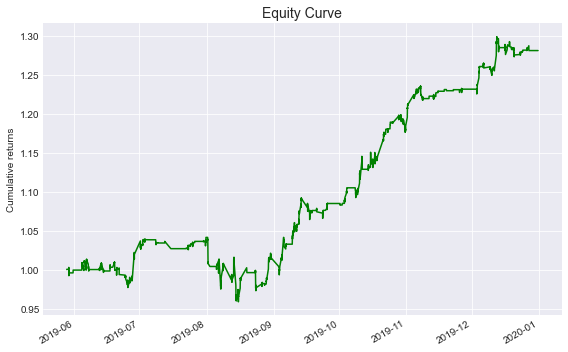

The cumulative return is 28.10%.


In [5]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(8, 5), 
                                         color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1) \
                    *100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

From the above output, you can see that the strategy generated a cumulative return of 28.10% in seven months. That is impressive. But this is not the only metric we need to see. Let us dive further to understand the performance of your strategy in detail.

You can analyse the returns generated by the strategy and the risk associated with them using different performance metrics.

#### Annualised Returns

The annualised return is the geometric average amount of money earned by an investment each year over a given time period. It shows what strategy would earn over a period of time if the annual return was compounded. It is calculated using the below formula:

$$ Annualised~Returns = (Cumulative~Returns^\frac{252*6.5*4}{no.~of~15-minute~data points}) - 1 $$

Note: There are approximately 252 trading days in a year, and 6.5 trading hours in a day. Since we are working with 15-minute data, the number of trading frequencies in a year is $252*6.5*4$. 

And the numerator in the exponent term is $252*6.5*4$.

In [6]:
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) \
                     **(252*6.5*4/strategy_data.shape[0]) - 1) \
                     * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 52.20%.


From the above output, you can see that the average annual return of the strategy is 52.20%. But how volatile is the asset? You can find that out using annual volatility.


#### Annualised Volatility<br>

Volatility is the measure of risk. It is defined as the standard deviation of the returns of the investment. Annualised volatility can be calculated by multiplying the daily volatility with the square root of the number of trading days in a year.

$$ \text{Annualised Volatility} = \sqrt{\text{Var(Returns)}}*\sqrt{252*6.5*4}$$

In [7]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'] \
                        .std()*np.sqrt(252*6.5*4) * 100
print("The annualised volatility is {0:.2f}%." \
      .format(annualised_volatility))

The annualised volatility is 14.90%.


Annualised volatility of 14.90% means that for approximately 68% time in a year, the current time's price would differ by less than 14.90% from the previous time. 

This is interesting. But volatility as a term treats positive and negative terms as the same. You would like to know how much the portfolio can go in the negative territory. You can check that using maximum drawdown.

#### Maximum Drawdown

Maximum drawdown is the maximum value a portfolio lost from its peak. It is the maximum loss the strategy can make. The higher the value of the drawdown, the higher would be the losses. It is calculated as below:

$$ Maximum~Drawdown = \frac{Trough~Value-Peak~Value}{Peak~Value} $$

The maximum drawdown is -7.94%.


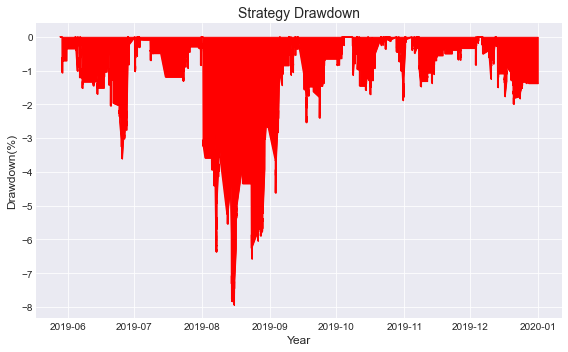

In [8]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) \
             * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(8, 5))

# Plot the maximum drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

From the above output, you can see that the maximum drawdown is 7.94%. This means that the maximum value that the portfolio lost from its peak was 7.94%. 

As with any investment, you can calculate the Sharpe ratio as well, to understand how well the strategy performs.

#### Sharpe Ratio

Sharpe ratio measures the performance of a portfolio when compared to a risk-free asset. It is the ratio of the returns earned in excess of the risk-free rate to the volatility of the returns. It is calculated as below:

$$ Sharpe~ratio = \frac{R_p-R_f}{\sigma_p}$$

where,

- $R_p$ is the return of the portfolio.
- $R_f$ is the risk-free rate.
- $\sigma_p$ is the volatility.

A portfolio with a higher Sharpe ratio will be preferred over a portfolio with a lower Sharpe ratio.

In [9]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'] \
                     .mean()/strategy_data['strategy_returns'] \
                     .std() * np.sqrt(252*6.5*4), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 2.89.


The Sharpe ratio of 2.89 indicates that the returns are pretty good when compared to the risk associated.

Note that to keep the chapter simple, the transaction cost and slippage were not considered while analysing the performance of the strategy. But this is an important concept too.
Also, since the risk free rate depends on the region as well as the time period, we have preferred to keep it 0. You can of course plug it in the formula to calculate it yourself.

<b> How should you define risk metrics for yourself?</b>

Volatility and maximum drawdown are the standard measures of risk. If you are concerned about the maximum loss a strategy can incur over a period of time. Then you can use maximum drawdown.

Traders also use the Sharpe ratio as it provides information about the returns per unit risk. So, it is using both factors, risk and returns.

It is important to note that we have not considered the transaction costs, commissions, slippages and taxes while calcuting the strategy returns and different metrics.

#### Backtesting vs Walk Forward Trading Testing

Backtesting a strategy gives you a good understanding of what happened in the past, but it's not a predictor of the future. Walk forward testing is a better approach which to some extent, can tell the future.

In the walk forward testing method, we divide the historical data in the training (in-sample) and testing (out-of-sample) dataset. On the training dataset, we optimise the trading parameters and check the performance of the strategy on the testing datasets.

Suppose you have ten years of data.

You take the first three years of data as train and keep the 4th year as test.
You then assess the performance for the 4th year using various performance metrics.

Next, you repeat the optimisation using data from years 2–4, and validate using month 5. You keep repeating this process until you've reached the end of the data. You collate the performances of all the out-of-sample data from year 4 to 10, which is your out-of-sample performance.

#### Paper Trading & Live Trading

You created the strategy and analysed the performance of the strategy.

<b>Can you directly start a paper or live trading?</b>

<b> When should you consider your strategy for paper trading or live trading? </b>

If you are satisfied with the backtesting strategy performance, then you can start paper trading. If not, you should tweak the strategy until the performance is acceptable to you. And once the paper trading results are satisfactory, you can start live trading.

<b>Process of Paper trading and Live trading</b>

<b> How many backtests should you do before taking a strategy live?</b><br>

There is no fixed number. You can take your strategy live after backtesting once or it can be after multiple backtesting. As we mentioned in the previous question, once you are satisfied with the backtesting results, you can consider your trading strategy for paper trading and live trading.

A good backtester should be aware of certain drawbacks/biases which might drastically change your backtesting results. Let's look at them one by one.

#### Overfitting/Optimisation Bias

Backtesting, like any other model, is prone to overfitting. While testing the model on historical data, you inadvertently try to fit the parameters to get the best results. 

You get the best result on the historical dataset, but when you deploy the same model on the unseen dataset, it might fail to give the same result.

The best way to avoid overfitting is:

- To divide the dataset into train and test datasets.
- You backtest your trading strategy on the training dataset and run your strategy on the test dataset with the same parameters that you used on the training dataset to ensure the effectiveness of the strategy.

#### Look-ahead Bias

Look-ahead bias is the use of information in the analysis before the time it would have actually occurred. 

While devising a strategy, you have access to the entire data. Thus, there might be situations where you include future data that was not able in the time period being tested.

A seemingly insignificant oversight, such as assuming that the earning report being available one day prior, can lead to skewed results during the backtesting. 

You need to make sure you are not using data that will only be available in the future to avoid look-ahead bias.

#### Survivorship Bias

During backtesting the strategy, you often tend to backtest a strategy on the current stock universe rather than the historical stock universe. That is, you use the universe that has survived until today to backtest.

There is a famous example that is used to illustrate the survivorship bias.

If you were to use stocks of technology companies to formulate a strategy, but took the data after the dot com bubble burst, it would present a starkly different scenario than if you had included it before the bubble burst.

It's a simple fact, after the year 2000, the companies which survived did well because their fundamentals were strong, and hence your strategy would not be including the whole universe. Thus, your backtesting result might not be able to give the whole picture.

#### Backtesting Software

There are platforms available that provide the functionality to perform backtesting on historical data. The important points to consider before selecting a backtesting platform are:

- Which asset classes does the platform support?
- Sources of the market data feeds it supports
- Which programming languages can be used to code the trading strategy which is to be tested?

Some of the common backtesting software and live trading software are:

1. Blueshift
2. MetaTrader
3. Amibroker
4. QuantConnect
5. Quanthouse, etc.


While this has already been said before, it is not necessary that the past is always representative of the future. 

Hence, it is important to note that you should not over-rely on backtesting. For example, the COVID pandemic in 2020 was the first of its kind and had an impact on global markets. 

The rules identified on the historical data might not have performed well during this pandemic.

Great! You have successfully built your own machine learning algorithm and not only have you tested it on historical data, but also analysed its results.

Before you go ahead and start live trading, there might be some things you need to care about first. In the next section, we will answer some of the most common questions when it comes to applying the machine learning model in live markets.